In [ ]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
print(IN_COLAB)

True


In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 794640645902995522
 xla_global_id: -1]

In [ ]:
if IN_COLAB:
  print("colab mode")
  from google.colab import drive
  drive.mount("/content/working_drive")
  train_file = '/content/working_drive/MyDrive/빅예분4팀 /dataset/train_final.csv'
  test_file = '/content/working_drive/MyDrive/빅예분4팀 /dataset/test_final.csv'
  submission_file = '/content/working_drive/MyDrive/빅예분4팀 /dataset/submission.csv'
else:
  print("not colab mode")
  train_file = './dataset/train_final.csv'
  test_file = './dataset/test_final.csv'
  submission_file = './dataset/submission.csv'

colab mode
Drive already mounted at /content/working_drive; to attempt to forcibly remount, call drive.mount("/content/working_drive", force_remount=True).


# 라이브러리 및 데이터
### 필요한 라이브러리들을 설치합니다.
#### 빈 env환경을 만들어서 테스트 필요

In [ ]:
!pip install factor-analyzer
!pip install ngboost
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
# from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.metrics import mean_squared_error, accuracy_score
from ngboost import NGBRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
# import seaborn as sns
import lightgbm as lgb
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
# from pytimekr import pytimekr
# import math
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_kmo
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
import warnings
warnings.filterwarnings('ignore')

### 데이터 불러오기

In [ ]:
data = pd.read_csv(train_file)
train = data.copy()
test = pd.read_csv(test_file)
submission = pd.read_csv(submission_file)

In [ ]:
train.shape, test.shape, submission.shape

((600, 23), (243, 22), (243, 2))

# 리뷰 카운트는 이미 상영이 시작하고난 후 데이터이므로 제거

In [ ]:
train = train.drop(labels = 'review_cnt', axis = 1)
test = test.drop(labels = 'review_cnt', axis = 1)

In [ ]:
train.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   title                 600 non-null    object 
 1   distributor           600 non-null    object 
 2   genre                 600 non-null    object 
 3   release_time          600 non-null    object 
 4   time                  600 non-null    int64  
 5   screening_rat         600 non-null    object 
 6   director              600 non-null    object 
 7   dir_prev_bfnum        600 non-null    float64
 8   dir_prev_num          600 non-null    int64  
 9   num_staff             600 non-null    int64  
 10  num_actor             600 non-null    int64  
 11  box_off_num           600 non-null    int64  
 12  actors                600 non-null    object 
 13  distributor_rank      600 non-null    int64  
 14  genre_rank            600 non-null    int64  
 15  actor_max_num         6

(None, None)

### 관객수(목적변수)와 무관한 데이터 제거

In [ ]:
train = train.drop(labels = 'actors', axis = 1)
train = train.drop(labels = 'release_time', axis = 1)
train = train.drop(labels = 'release_time_year', axis = 1)
train = train.drop(labels = 'release_time_month', axis = 1)
train = train.drop(labels = 'num_actor', axis = 1)
train = train.drop(labels = 'title', axis = 1)
train = train.drop(labels = 'director', axis = 1)
train = train.drop(labels = 'distributor', axis = 1)
train = train.drop(labels = 'actor_max', axis = 1)
train = train.drop(labels = 'genre', axis = 1)

test = test.drop(labels = 'actors', axis = 1)
test = test.drop(labels = 'release_time', axis = 1)
test = test.drop(labels = 'release_time_year', axis = 1)
test = test.drop(labels = 'release_time_month', axis = 1)
test = test.drop(labels = 'num_actor', axis = 1)
test = test.drop(labels = 'title', axis = 1)
test = test.drop(labels = 'director', axis = 1)
test = test.drop(labels = 'distributor', axis = 1)
test = test.drop(labels = 'actor_max', axis = 1)
test = test.drop(labels = 'genre', axis = 1)


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   time                  600 non-null    int64  
 1   screening_rat         600 non-null    object 
 2   dir_prev_bfnum        600 non-null    float64
 3   dir_prev_num          600 non-null    int64  
 4   num_staff             600 non-null    int64  
 5   box_off_num           600 non-null    int64  
 6   distributor_rank      600 non-null    int64  
 7   genre_rank            600 non-null    int64  
 8   actor_max_num         600 non-null    float64
 9   release_time_weekday  600 non-null    int64  
 10  season                600 non-null    int64  
 11  holiday               600 non-null    int64  
dtypes: float64(2), int64(9), object(1)
memory usage: 56.4+ KB


### 무엇을 label encoding하고 무엇을 onehotencoding할것인지?
- 카테고리형 데이터(Categorical Data)를 수치형 데이터(Numerical Data)로 변환해주는 작업은 머신러닝 모델을 돌려보기 위해서 필수로 해줘야하는 전처리 작업입니다.

관련 문서 : https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html


In [ ]:
le_screening_rat = LabelEncoder()
train['screening_rat'] = le_screening_rat.fit_transform(train['screening_rat'])
test['screening_rat'] = le_screening_rat.fit_transform(test['screening_rat'])

In [ ]:
train.head()

,time,screening_rat,dir_prev_bfnum,dir_prev_num,num_staff,box_off_num,distributor_rank,genre_rank,actor_max_num,release_time_weekday,season,holiday
0,96,3,0.00,0,91,23398,134,11,3752789.0,3,4,0
1,130,3,1161602.50,2,387,7072501,145,12,4745863.8,3,4,0
2,123,1,220775.25,4,343,6959083,145,11,3487385.0,2,3,0
3,101,2,23894.00,2,20,217866,140,9,679544.0,3,3,0
4,108,1,1.00,1,251,483387,145,9,661605.8,3,4,0


##요인분석
- 요인분석은 관측된 변수 집합에서 영향력 있는 기본 요인 또는 잠재 요인을 검색하는 데 사용되는 탐색적 데이터 분석 방법이다.
- 요인 분석은 선형 통계 모형이다.

가정 :  
1. 데이터에는 특이치가 없다.
2. 표본 크기는 요인보다 커야 한다.
3. 완벽한 다중 공선성은 없어야 한다.
4. 변수들 사이에 동질성이 있어서는 안 된다.

###요인 수 선택
- 카이저 기준은 분석적 접근법으로, 요인별로 설명되는 더 유의미한 분산 비율을 기준으로 선택한다. 고유값은 요인 수를 결정하는 데 좋은 기준이다. 일반적으로 1보다 큰 고유값은 피쳐의 선택 기준으로 간주된다.

### 적합성 검정
- 요인 분석을 수행하기 전에 데이터 세트의 "인자 가능성"을 평가해야 한다. 요인 분석 가능성은 "데이터 세트에서 요인을 찾을 수 있는가?"를 의미한다. 요인 분석 가능성 또는 표본 추출 적합성을 확인하는 두 가지 방법이 있다.
1. 바틀렛 테스트
2. KMO(Kaise-Meyer-Olkin)테스트

###바틀렛 테스트
- 모집단으로부터 추출한 표본의 상관계수 행렬의 행렬식 값을 값을 계산하여 상관계수 행렬이 단위행렬인지 아닌지 카이제곱분포를 이용해서 검정하는 방법.

In [ ]:
ml_columns = ['time','dir_prev_bfnum','dir_prev_num','num_staff','box_off_num',
              'distributor_rank','genre_rank','actor_max_num','season',
              'release_time_weekday', 'screening_rat']
chi_square_value,p_value=calculate_bartlett_sphericity(train[ml_columns])
print("카이제곱 :", chi_square_value)
print("p_value :", p_value)


카이제곱 : 2098.096652496053
p_value : 0.0


- P < 0.05
- p-value가 0이므로 탐색적 요인분석에 적합한 데이터라고 할 수 있다

###KMO 테스트
- 요인 분석에 대한 데이터의 적합성을 측정한다. 각 관측 변수와 전체 모형에 대한 적합성을 결정한다. KMO는 모든 관측 변수 간의 분산 비율을 추정한다. KMO값의 범위는 0에서 1 사이이다. 0.6미만의 KMO 값은 부적합한 것으로 간주된다.

In [ ]:
kmo_all,kmo_model=calculate_kmo(train[ml_columns])
kmo_model

0.8487214097081547

- 데이터 전체 KMO는 0.84로 매우 좋음. 이 값은 요인 분석을 계속할 수 있음을 나타낸다.

###요인수 선택
- 고유값이 1이상인 요인을 선택한다.

In [ ]:
fa = FactorAnalyzer()
fa.fit(train[ml_columns])

# Check Eigenvalues
ev, v = fa.get_eigenvalues()
fa_cnt = len([i for i in ev if i >=1])
print(ev)
print("고유값이 1 이상인 요인 수는 {}개 입니다.".format(fa_cnt))

[4.13512521 1.10647872 1.02962234 0.94147809 0.91060793 0.73058203
 0.63065558 0.57006191 0.44625937 0.26766274 0.23146609]
고유값이 1 이상인 요인 수는 3개 입니다.


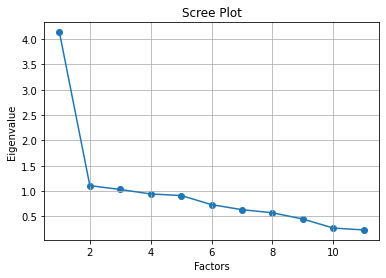

In [ ]:
plt.scatter(range(1,train[ml_columns].shape[1]+1),ev)
plt.plot(range(1,train[ml_columns].shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

### 요인 분석 수행
- 고유값이 1이상인 요인수로 분석 수행

In [ ]:
fa = FactorAnalyzer(fa_cnt, rotation='varimax')
fa.fit(train[ml_columns])
df1= pd.DataFrame(fa.loadings_, index=ml_columns)
df1

,0,1,2
time,0.653113,0.267502,0.215662
dir_prev_bfnum,0.159755,0.222265,0.413121
dir_prev_num,0.146070,0.117732,0.835163
num_staff,0.731821,0.371103,0.375809
box_off_num,0.264511,0.824597,0.146678
distributor_rank,0.568014,0.290770,0.286302
genre_rank,0.455592,0.142028,0.166010
actor_max_num,0.387447,0.741460,0.203399
season,-0.092239,-0.060508,0.035756
release_time_weekday,-0.182114,-0.310957,-0.127563


### 절대값이 0.5 이상인것만 선택한다.

In [ ]:
df1 = df1.abs().max(axis=1)
fa_columns = df1[df1>=0.5].index
print(fa_columns)

Index(['time', 'dir_prev_num', 'num_staff', 'box_off_num', 'distributor_rank',
       'actor_max_num'],
      dtype='object')


### 3가지 요인에 의해 설명되는 총 43%의 누적 분산이다.

In [ ]:
fa.get_factor_variance()
df_tmp = pd.DataFrame(fa.get_factor_variance(), index = ["SS Loadings","Proportion Var","Cumulative Var"])
df_tmp

,0,1,2
SS Loadings,1.808647,1.733982,1.259053
Proportion Var,0.164422,0.157635,0.114459
Cumulative Var,0.164422,0.322057,0.436517


In [ ]:
train.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   time                  600 non-null    int64  
 1   screening_rat         600 non-null    int64  
 2   dir_prev_bfnum        600 non-null    float64
 3   dir_prev_num          600 non-null    int64  
 4   num_staff             600 non-null    int64  
 5   box_off_num           600 non-null    int64  
 6   distributor_rank      600 non-null    int64  
 7   genre_rank            600 non-null    int64  
 8   actor_max_num         600 non-null    float64
 9   release_time_weekday  600 non-null    int64  
 10  season                600 non-null    int64  
 11  holiday               600 non-null    int64  
dtypes: float64(2), int64(10)
memory usage: 56.4 KB


,time,screening_rat,dir_prev_bfnum,dir_prev_num,num_staff,box_off_num,distributor_rank,genre_rank,actor_max_num,release_time_weekday,season,holiday
0,96,3,0.00,0,91,23398,134,11,3752789.0,3,4,0
1,130,3,1161602.50,2,387,7072501,145,12,4745863.8,3,4,0
2,123,1,220775.25,4,343,6959083,145,11,3487385.0,2,3,0
3,101,2,23894.00,2,20,217866,140,9,679544.0,3,3,0
4,108,1,1.00,1,251,483387,145,9,661605.8,3,4,0


### 로그 변환(Log Scaling) with np.log1p (EDA편 참고)
- 로그함수는 지수함수의 역함수이다. log(x)는 [1,10]의 범위를 [0,1]의 범위로, [10, 100] 범위를 [1,2] 범위로 맵핑한다. 즉 로그함수는 큰수의 범위를 압축하고 작은수의 범위를 확장한다. x가 커질수록 log(x)의 증가는 느려진다. (가로축에서 100-1000까지의 x 값은 세로축 y에서 2-3사이의 좁은 범위로 압축되지만, x값이 100보다 작은 매우 좁은 구간은 세로축에서 넓은 범위에 매핑된다)


|스케일링 적용 전 후 RMSE 값 비교|||
|------|-|-|
|모델|전|후|
|Random Forest|584910.0866821262|570859.104162598|
|LGBMRegressor|727637.9840893785|719205.6383624603|
|Tensorflow|1695097.3415371508|1695097.3415371508|
* 단, 최적화 전으로 값의 변화만 참고 할것

In [ ]:
train["actor_max_num"]=np.log1p(train["actor_max_num"])
train["num_staff"]=np.log1p(train["num_staff"])
train["dir_prev_bfnum"]=np.log1p(train["dir_prev_bfnum"])
train["dir_prev_num"]=np.log1p(train["dir_prev_num"])
#목적변수는 K-Fold를 사용한 예측시 값이 너무커져 오버플로우를 방지하기 위해 변환함, 예측 후 원복해야함.
train["box_off_num"]=np.log1p(train["box_off_num"])

test["actor_max_num"]=np.log1p(test["actor_max_num"])
test["num_staff"]=np.log1p(test["num_staff"])
test["dir_prev_bfnum"]=np.log1p(test["dir_prev_bfnum"])
test["dir_prev_num"]=np.log1p(test["dir_prev_num"])

In [ ]:
train.head()

,time,screening_rat,dir_prev_bfnum,dir_prev_num,num_staff,box_off_num,distributor_rank,genre_rank,actor_max_num,release_time_weekday,season,holiday
0,96,3,0.000000,0.000000,4.521789,10.060449,134,11,15.138010,3,4,0
1,130,3,13.965312,1.098612,5.961005,15.771725,145,12,15.372784,3,4,0
2,123,1,12.304905,1.609438,5.840642,15.755558,145,11,15.064663,2,3,0
3,101,2,10.081425,1.098612,3.044522,12.291640,140,9,13.429179,3,3,0
4,108,1,0.693147,0.693147,5.529429,13.088575,145,9,13.402427,3,4,0


In [ ]:
ml_train = train[ml_columns]
y = ml_train['box_off_num']
X = ml_train.drop(labels = 'box_off_num', axis = 1)

X.head(), y.head()

(   time  dir_prev_bfnum  dir_prev_num  num_staff  distributor_rank  \
 0    96        0.000000      0.000000   4.521789               134   
 1   130       13.965312      1.098612   5.961005               145   
 2   123       12.304905      1.609438   5.840642               145   
 3   101       10.081425      1.098612   3.044522               140   
 4   108        0.693147      0.693147   5.529429               145   
 
    genre_rank  actor_max_num  season  release_time_weekday  screening_rat  
 0          11      15.138010       4                     3              3  
 1          12      15.372784       4                     3              3  
 2          11      15.064663       3                     2              1  
 3           9      13.429179       3                     3              2  
 4           9      13.402427       4                     3              1  ,
 0    10.060449
 1    15.771725
 2    15.755558
 3    12.291640
 4    13.088575
 Name: box_off_num, dtype: fl

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2)

### 중요한 변수를 찾기 위해 Random Forest를 이용한다.


In [ ]:
rf = RandomForestRegressor(random_state = 518)

In [ ]:
model = RandomForestRegressor(n_jobs=-1)
model.fit(X_train, y_train)
importances = model.feature_importances_

Feature ranking:
1. distributor_rank (0.687)
2. actor_max_num (0.215)
3. num_staff (0.035)
4. time (0.032)
5. dir_prev_bfnum (0.008)
6. genre_rank (0.007)
7. season (0.007)
8. screening_rat (0.005)
9. dir_prev_num (0.003)
10. release_time_weekday (0.001)


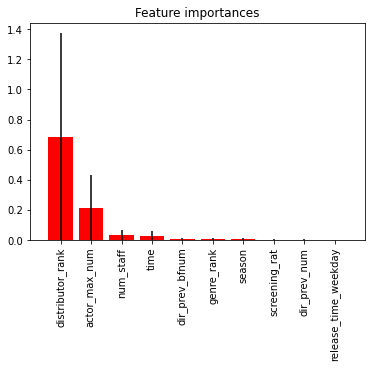

In [ ]:
indices = np.argsort(importances)[::-1]
fi_columns = []
# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("{}. {} ({:.3f})".format(f + 1, X.columns[indices][f], importances[indices[f]]))
    fi_columns.append(X.columns[indices][f])

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

### 디폴트 Feature Importance 결과를 믿는 것 보다는, Permutation Feature Importance와 같은 다른 방법을 혼합해서 사용하는 것이 더욱 추천됨

In [ ]:
perm_importance = permutation_importance(model, X_test, y_test)

Text(0.5, 0, 'Permutation Importance')

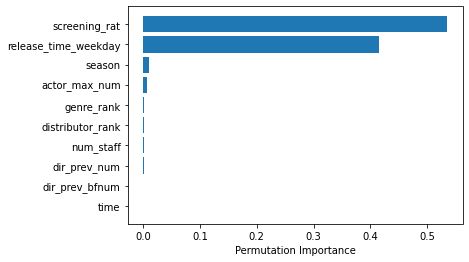

In [ ]:
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X.columns, perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

In [ ]:
pfi_columns = []
for f in range(X.shape[1]):
    pfi_columns.append(X.columns[sorted_idx][f])

## 변수 선택
### feature_importances로 뽑은 상위 4개

### permutation_importance로 뽑은 상위 4개 

### 위 두 그룹을 합쳐서 중요변수로 사용



In [ ]:
print("feature_importances 중요 변수 상위 4개\n",fi_columns[:4])

feature_importances 중요 변수 상위 4개
 ['distributor_rank', 'actor_max_num', 'num_staff', 'time']


In [ ]:
print("permutation_importance 중요 변수 상위 4개\n",pfi_columns[:4])

permutation_importance 중요 변수 상위 4개
 ['dir_prev_num', 'screening_rat', 'release_time_weekday', 'dir_prev_bfnum']


In [ ]:
rf_columns = list(set(fi_columns[:4]+pfi_columns[:4]))
print("두 그룹을 합쳐 중요변수로 사용\n",rf_columns)

두 그룹을 합쳐 중요변수로 사용
 ['release_time_weekday', 'distributor_rank', 'time', 'num_staff', 'actor_max_num', 'dir_prev_bfnum', 'screening_rat', 'dir_prev_num']


### 요인분석을 통한 Factor Loading 값과 Random Forest의 Feature Importance를 합쳐 종속변수로 사용

In [ ]:
h_columns = list(set(list(fa_columns)+rf_columns))
h_columns = [i for i in h_columns if i != 'box_off_num']
h_columns

['release_time_weekday',
 'time',
 'distributor_rank',
 'num_staff',
 'actor_max_num',
 'dir_prev_bfnum',
 'screening_rat',
 'dir_prev_num']

### 10Fold로 교차검증

In [ ]:
kf = KFold(n_splits =  10, shuffle = True, random_state = 42)

In [ ]:
result_rmse=[]

In [ ]:
X = X[h_columns]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2)
test = test[h_columns]

## 여러 모델로 학습하기 위해 공통 학습 함수를 정의

In [ ]:
def learn(model, X, y, test):
  rmse_list = []
  model_pred = np.zeros((test.shape[0]))
  for tr_idx, val_idx in kf.split(X, y) :
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
    model.fit(tr_x, tr_y)
    
    pred = np.expm1([0 if x < 0 else x for x in model.predict(val_x)])
    sub_pred = np.expm1([0 if x < 0 else x for x in model.predict(test)])
    rmse = np.sqrt(mean_squared_error(val_y, pred))
    
    rmse_list.append(rmse)
    
    model_pred += (sub_pred / 10)
  return rmse_list


### 1) RandomForestRegressor
- 앙상블 학습 방법의 일종으로, 훈련 과정에서 구성한 다수의 결정 트리로부터 부류(분류) 또는 평균 예측치(회귀 분석)를 출력함으로써 동작한다.

<p><a href="https://commons.wikimedia.org/wiki/File:Randomforests_ensemble.gif#/media/파일:Randomforests_ensemble.gif"><img src="https://upload.wikimedia.org/wikipedia/commons/c/c7/Randomforests_ensemble.gif" alt="Randomforests ensemble.gif"></a><br>


이미지 출처 : https://commons.wikimedia.org/wiki/File:Randomforests_ensemble.gif#/media/파일:Randomforests_ensemble.gif

관련 문서 : https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [ ]:
rmse_list = learn(RandomForestRegressor(random_state = 518), X, y, test)
result_rmse.append(np.mean(rmse_list))
print(f' RMSE  :', np.mean(rmse_list))

 RMSE  : 1234342.4272891302


### 2) GradientBoostingRegressor
- 랜덤 포레스트를 개선한 방법
- 분류의 실제 결과값(y), 피처에 기반한 예측 함수= F(x)
 - h(x) = y-F(x)를 최소화하는 방향성을 가지고 가중치 업데이트​

![GradientBoostingRegressor](https://www.researchgate.net/profile/Ivanna-Baturynska/publication/340524896/figure/fig3/AS:878319096569859@1586418999392/Schematical-representation-of-gradient-boosting-regression-in-regards-to-algorithm.png)

이미지 출처 : https://www.researchgate.net/figure/Schematical-representation-of-gradient-boosting-regression-in-regards-to-algorithm_fig3_340524896

관련 문서 : https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html


In [ ]:
rmse_list = learn( GradientBoostingRegressor(random_state = 42), X, y, test)
result_rmse.append(np.mean(rmse_list))
print(f' RMSE  :', np.mean(rmse_list))

 RMSE  : 1271788.6800387737


### 3) XGBRegressor
- 여러 개의 결정 트리를 임의적으로 학습하는 앙상블의 부스팅 유형
- 순차적 학습 방법 => 약한 분류기를 강한 분류기로 만듦
- 분류정확도는 우수하나, Outlier에 취약함
- GBM 대비 빠른 수행시간
  - 병렬 처리로 학습, 분류 속도가 빠르다.
- 과적합 규제(Regularization)
  - 표준 GBM 경우 과적합 규제기능이 없으나, XGBoost는 자체에 과적합 규제 기능으로 강한 내구성 지닌다.
- 분류와 회귀영역에서 뛰어난 예측 성능 발휘
  - 즉, CART(Classification and regression tree) 앙상블 모델을 사용
- Early Stopping(조기 종료) 기능이 있음
- 다양한 옵션을 제공하며 Customizing이 용이하다.

In [ ]:
rmse_list = learn(XGBRegressor(random_state = 518, verbose =0), X, y, test)
result_rmse.append(np.mean(rmse_list))
print(f' RMSE  :', np.mean(rmse_list))

[07:42:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:42:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:42:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:42:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:42:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:42:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:42:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:42:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

### 4) LightGBM
- 부스팅 모델
- 기존 모델이 못 맞춘 문제에 가중치를 두어 지속적으로 학습 이어나감
- 타 부스팅 모델에 비해 속도가 빠름

![부스팅](https://quantdare.com/wp-content/uploads/2016/04/bb3.png)

이미지 출처 : https://quantdare.com/what-is-the-difference-between-bagging-and-boosting/

관련 자료 : https://mac-user-guide.tistory.com/79

In [ ]:
rmse_list = learn(lgb.LGBMRegressor(random_state=1, n_estimators=1000), X, y, test)
result_rmse.append(np.mean(rmse_list))
print(f' RMSE  :', np.mean(rmse_list))

 RMSE  : 1581477.0060240491


### 5) NGBRegressor
- 스탠퍼드 ML Group에서 발표한 부스팅 알고리즘
- NGBoost는 XGBoost나 LightBoost보다 성능이 조금 더 좋습니다
- 확률적인 예측을 해줍니다. (예측의 불확실성을 측정해줍니다.)



![Ordinary Gradient](https://stanfordmlgroup.github.io/projects/ngboost/img/toy_naive.gif)
![Natural Gradient](https://stanfordmlgroup.github.io/projects/ngboost/img/toy_natural.gif)

이미지 출처 : https://stanfordmlgroup.github.io/projects/ngboost/

관련 논문 : https://arxiv.org/pdf/1910.03225.pdf

관련 자료 : https://stanfordmlgroup.github.io/ngboost/1-useage.html

In [ ]:
rmse_list = learn(NGBRegressor(random_state = 518, verbose = 0), X, y, test)
result_rmse.append(np.mean(rmse_list))
print(f' RMSE  :', np.mean(rmse_list))

 RMSE  : 1455335.3789742768


### 6) CatBoostRegressor
- 기존 부스팅 모델의 문제인 느린 학습 속도와 오버피팅을 해결한 모델
- 기존의 부스팅 모델이 일괄적으로 모든 훈련 데이터를 대상으로 잔차계산을 했다면, Catboost 는 일부만 가지고 잔차계산을 한 뒤, 이걸로 모델을 만들고, 그 뒤에 데이터의 잔차는 이 모델로 예측한 값을 사용한다.

![false positive rates for XGBoost, CatBoost, and LightGBM as number of features used increases](https://media.springernature.com/full/springer-static/image/art%3A10.1186%2Fs40537-020-00369-8/MediaObjects/40537_2020_369_Fig4_HTML.png)

이미지 출처 : https://media.springernature.com/lw685/springer-static/image/art%3A10.1186%2Fs40537-020-00369-8/MediaObjects/40537_2020_369_Fig4_HTML.png?as=webp

관련 문서 : https://journalofbigdata.springeropen.com/articles/10.1186/s40537-020-00369-8



In [ ]:
rmse_list = learn(CatBoostRegressor(random_state = 518, silent = True), 
                  X, y, test)
result_rmse.append(np.mean(rmse_list))
print(f' RMSE  :', np.mean(rmse_list))

 RMSE  : 1324185.591123933


### 7) Tensorflow linear

In [ ]:
X_train.shape

(480, 8)

In [ ]:
model = tf.keras.Sequential()
model.add(Dense(64, input_shape=(len(X_train.columns),), activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))

model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(0.001),metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 64)                576       
                                                                 
 dense_11 (Dense)            (None, 64)                4160      
                                                                 
 dense_12 (Dense)            (None, 32)                2080      
                                                                 
 dense_13 (Dense)            (None, 16)                528       
                                                                 
 dense_14 (Dense)            (None, 1)                 17        
                                                                 
Total params: 7,361
Trainable params: 7,361
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, validation_split=0.01, verbose=0, epochs=100)

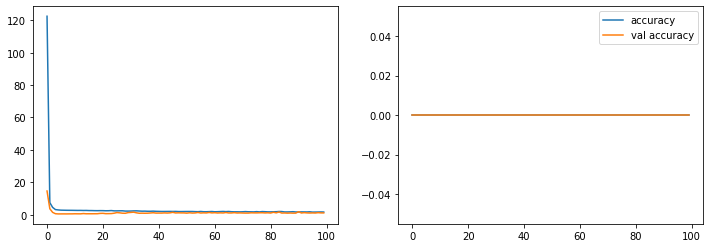

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()

In [ ]:
pred = np.expm1([0 if x < 0 else x for x in model.predict(X_test)])
mse = ((pred - np.expm1(y_test.to_numpy()))**2).mean()
print("RMSE : ", np.sqrt(mse))

4/4 [==============================] - 0s 3ms/step
RMSE :  1225483.9880679836
